## Các câu hỏi cần phân thích và dự báo kết quả vietlott
1. Trong lịch sử các kỳ quay, tần suất và xác suất xuất hiện của các số như thế nào? Vẽ biểu đồ cột và biểu đồ xoắn ốc
2. Các số xuất hiện theo phân bố xác suất nào?
3. Lấy giá trị giải jackpot 1 theo từng kỳ quay và vẽ biểu đồ chênh tăng giá trị giải theo từng kỳ quay.
4. Tính chênh chênh lệch giữa các ball theo từng kỳ
5. Tính tổng các ball và kiểm tra phân phối

## 1. Nhập các thư viện cần thiết và tiền xử lý dữ liệu

In [136]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sqlalchemy import create_engine


from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, GRU, LSTM
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

from scipy.stats import shapiro



In [78]:
# Tạo engine kết nối với SQL Server sử dụng SQLAlchemy
engine = create_engine('mssql+pyodbc://WHITEKING\WHITEKING/vietlott?driver=ODBC+Driver+17+for+SQL+Server&trusted_connection=yes')

# Sử dụng engine để thực hiện truy vấn và lấy dữ liệu vào DataFrame
prize_result = pd.read_sql('SELECT * FROM vietlott.power.prize_result_power', engine)
draw_result = pd.read_sql('SELECT * FROM vietlott.power.draw_result_power', engine)

Kiểm tra các thông số cơ bản của 2 dữ liệu prize_result, draw_result. Chúng ta thấy trường draw_date của cả 2 dataframe đều chưa đúng định dạng date, đồng thời các cột ball_x của draw_result đang để định dạng oject mà không phải định dạng số (int). Tuy nhiên chúng ta sẽ giữ lại định dạng object này để hiển thị cho chính xác

In [6]:
prize_result.info()
draw_result.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5090 entries, 0 to 5089
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   prize              5090 non-null   object
 1   number_of_prizes   5090 non-null   int64 
 2   prize_value        5090 non-null   int64 
 3   draw_ID            5090 non-null   int64 
 4   draw_date          5090 non-null   object
 5   winning_condition  5090 non-null   object
dtypes: int64(3), object(3)
memory usage: 238.7+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1018 entries, 0 to 1017
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   draw_ID       1018 non-null   int64 
 1   draw_date     1018 non-null   object
 2   ball_1        1018 non-null   object
 3   ball_2        1018 non-null   object
 4   ball_3        1018 non-null   object
 5   ball_4        1018 non-null   object
 6   ball_5        1018 

Chúng ta ép kiểu cho trường draw_date thành dạng date yyyy-mm-dd

In [7]:
# draw_result = draw_result.astype({'draw_date': 'datetime64[ns]'})
# prize_result = prize_result.astype({'draw_date': 'datetime64[ns]'})
draw_result['draw_date'] = pd.to_datetime(draw_result['draw_date'], format='%Y-%m-%d')
prize_result['draw_date'] = pd.to_datetime(prize_result['draw_date'], format='%Y-%m-%d')

## 2. Phân tích tổng quan toàn bộ các kết quả

Dựa trên lịch sử các kỳ quay từ trước đến giờ, chúng ta sẽ phân tích, trực quan hóa... và cố gắng tìm kiếm các mối quan hệ lặp lại có ý nghĩa

### Số nóng và số lạnh

Số nóng là những số xuất hiện thường xuyên nhất trong các kỳ quay. Bạn có thể cân nhắc những con số “may mắn” này để chọn. 22, 23 và 51 là con số hot nhất của chúng ta.

Ngược lại, số lạnh sẽ xuất hiện ít thường xuyên hơn. Một số ngẫu nhiên có thể được xuất hiện trong các kỳ quay gần đây, nhưng tổng thể nó được quay trúng là dưới mức trung bình. Bạn có thể cân nhắc những con số không may mắn này. 16, 28, 37 là con số lạnh lùng nhất của chúng ta!

Mỗi người đều có những con số yêu thích, vì vậy khi những con số phổ biến xuất hiện, bạn đang chia sẻ số tiền thắng cược với nhiều người. Sinh nhật là những lựa chọn phổ biến, vậy mọi người có chọn số 1-12 và 1-31 thường xuyên hơn không? Nếu vậy có lẽ bạn nên chọn những con số không phổ biến để khi thắng bạn sẽ nhận được nhiều tiền hơn.

In [92]:
# Thống kê số lần xuất hiện của từng số
# Hàm stack() để để xếp dữ liệu thành chiều dọc và đếm chúng với hàm value_counts()
# Cuối tuần ta sẽ dùng hàm sort_values(ascending=True) để xếp theo tự tự tần suất từ bé đến lớn
frequency_number = draw_result.iloc[:, 2:8] \
                                .stack() \
                                .value_counts() \
                                .sort_values(ascending=True)
frequency_number

28     96
16     96
37     96
07     98
02     99
04    100
15    100
39    101
27    102
14    103
06    103
30    104
21    104
54    104
26    104
10    104
36    104
17    105
45    105
50    106
25    106
38    106
19    109
40    109
31    109
13    110
55    111
05    111
35    111
20    112
42    114
52    115
01    115
24    116
46    116
18    117
53    117
29    117
48    117
33    118
43    118
11    119
09    119
49    120
34    120
47    120
08    120
41    121
12    121
44    122
03    123
32    123
22    124
51    124
23    124
Name: count, dtype: int64

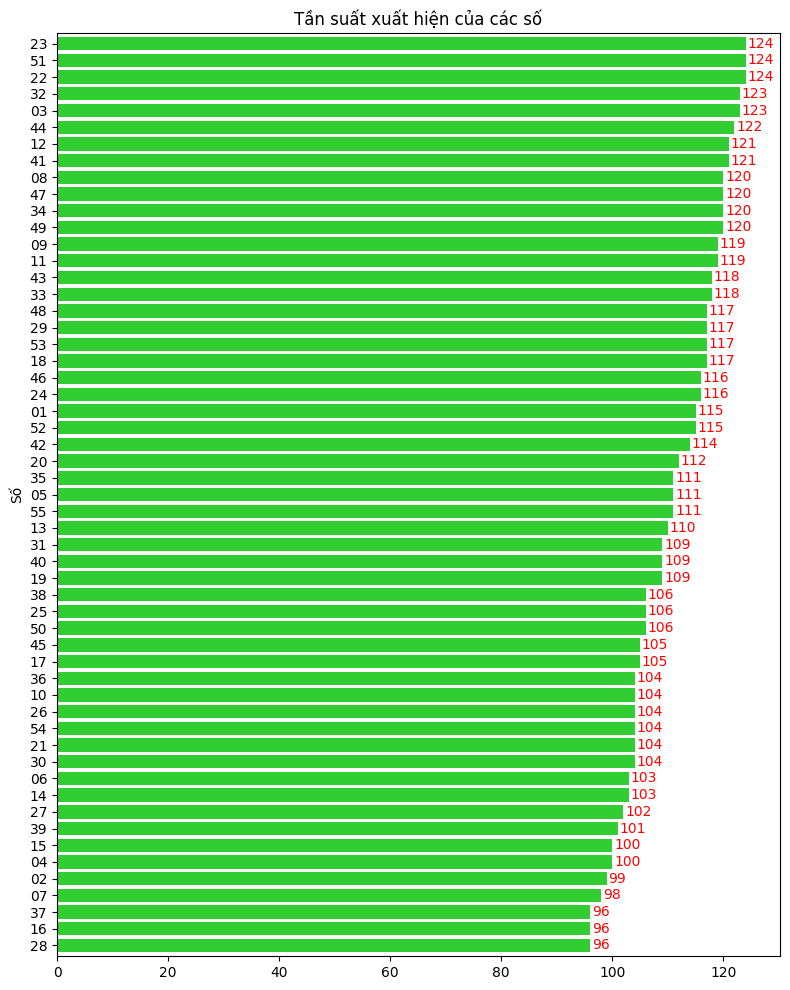

In [100]:
frequency_number.plot(kind='barh', figsize=(8, 10), color='limegreen', width=0.8)
# plt.xlabel('Tần suất xuất hiện')
plt.ylabel('Số')
plt.title('Tần suất xuất hiện của các số')

# Hiển thị số liệu bên phải mỗi cột với màu đỏ
for i, (index, value) in enumerate(frequency_number.items()):
    plt.text(value + 0.3, i, str(value), color='red', va='center')

plt.tight_layout()
plt.show()

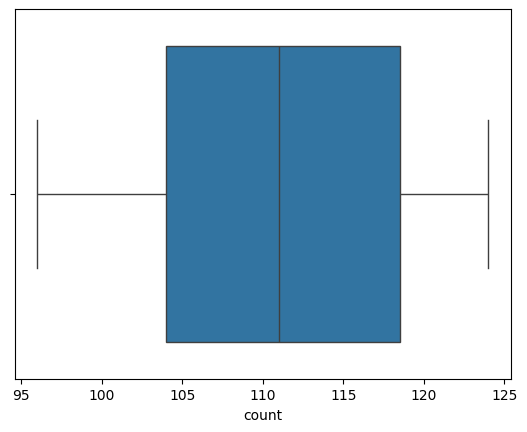

In [10]:
ax = sns.boxplot(x=frequency_number)

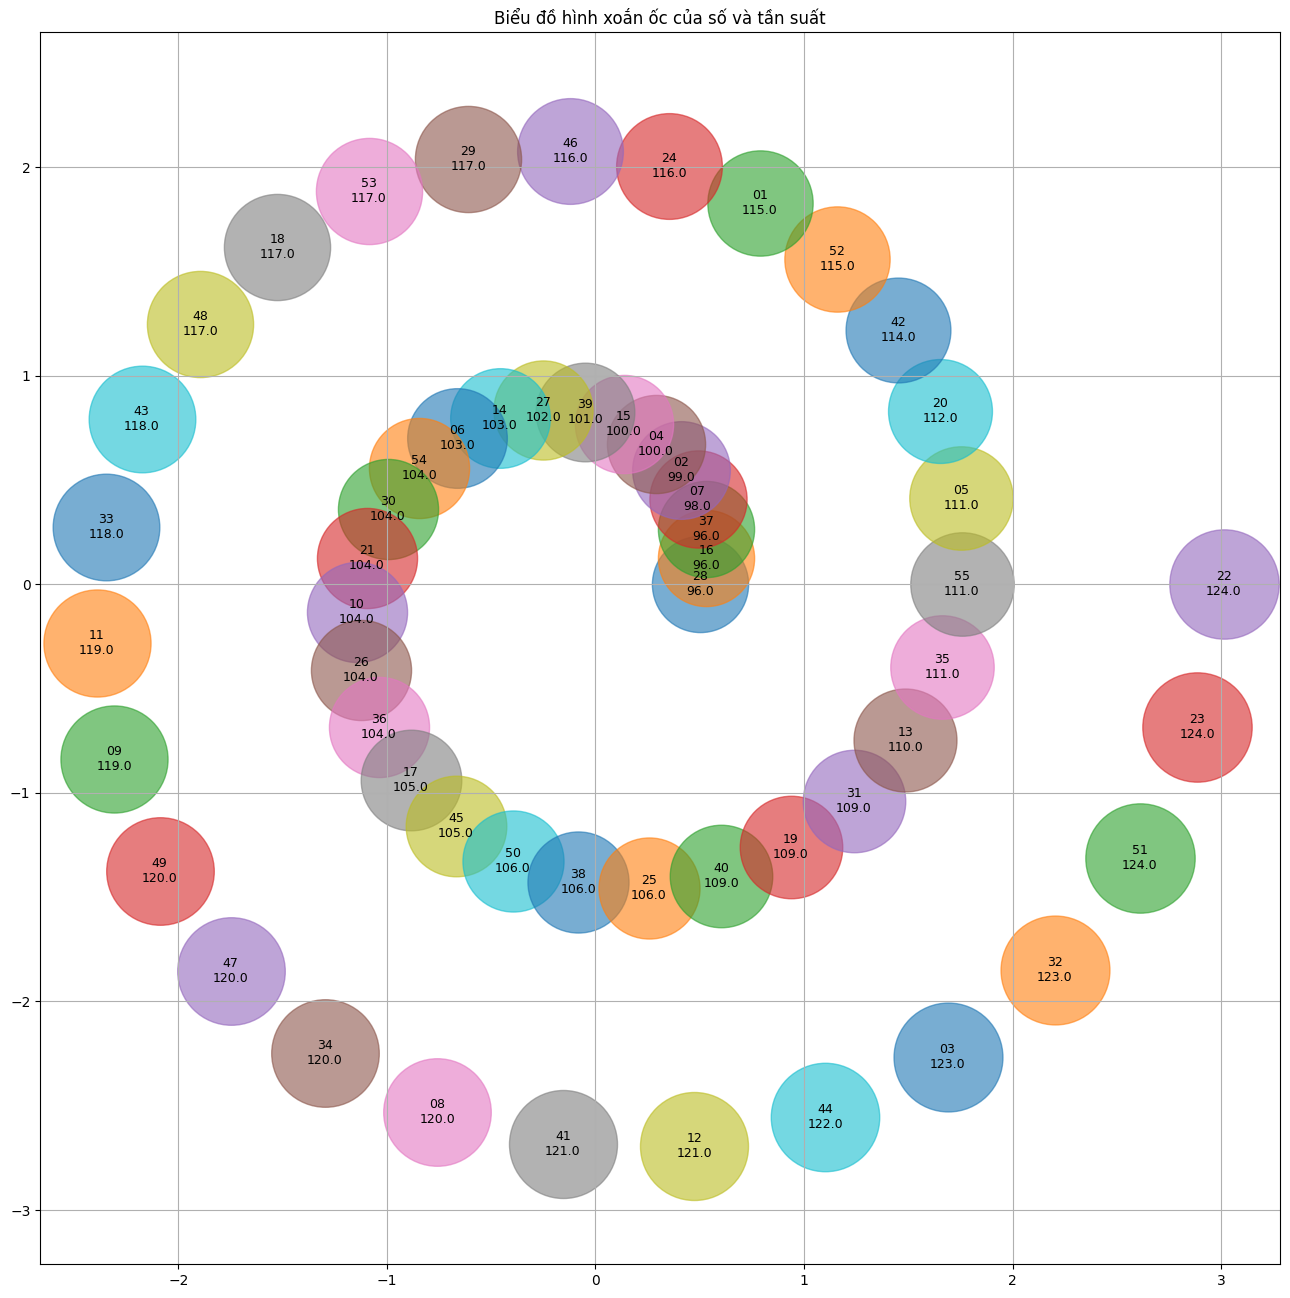

In [97]:
# Chuyển series thành DataFrame
data = frequency_number.reset_index()

# Đổi tên các cột
data.columns = ['number', 'frequency']


# Chuyển đổi dữ liệu thành DataFrame và tính trung bình tần suất cho mỗi số
df = pd.DataFrame(data)
df_grouped = df.groupby('number', as_index=False)['frequency'].mean()

# Sắp xếp dữ liệu theo tần suất từ thấp đến cao
df_sorted = df_grouped.sort_values(by='frequency', ascending=True).reset_index(drop=True)

# Tính toán vị trí trên xoắn ốc
a, b = 0.5, 0.2  # Các tham số cho xoắn ốc Archimedes
theta = np.linspace(0, 4 * np.pi, len(df_sorted))  # Tạo một mảng các giá trị theta
r = a + b * theta  # Tính bán kính từ tâm xoắn ốc

# Tính toán vị trí x, y dựa trên r và theta
x = r * np.cos(theta)
y = r * np.sin(theta)

# Vẽ biểu đồ
plt.figure(figsize=(16, 16))
plt.axis('equal')  # Đảm bảo tỉ lệ trục x và y như nhau

# Vẽ các điểm dựa trên tần suất và vị trí tính toán, tăng kích thước quả bóng
for i, (xx, yy, freq, number) in enumerate(zip(x, y, df_sorted['frequency'], df_sorted['number'])):
    plt.scatter(xx, yy, s=freq * 50, alpha=0.6)  # Tăng kích thước quả bóng
    plt.text(xx, yy, f'{number}\n{freq}', fontsize=9, ha='center', va='center')

plt.title('Biểu đồ hình xoắn ốc của số và tần suất')
# plt.xlabel('X Axis')
# plt.ylabel('Y Axis')
plt.grid(True)
plt.show()

Vẽ biểu đồ tần suất xuất hiện của ball

Vẽ đơn giản

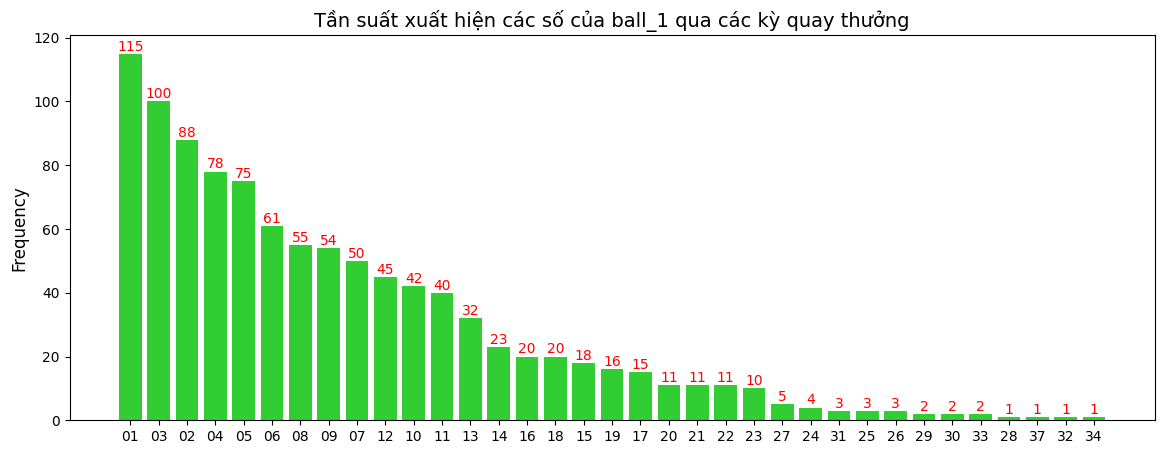

In [13]:
fig, ax = plt.subplots(figsize=(14,5))
bars = ax.bar(draw_result['ball_1'].value_counts().index,
              draw_result['ball_1'].value_counts().values,
              color='limegreen')  # Đặt màu cho cột tại đây
# Đặt màu cho cột
# colors = ['red', 'green', 'blue', 'cyan', 'magenta', 'yellow', 'black', 'white']  # Bạn có thể thay đổi danh sách màu

# Thêm số liệu trên đầu các cột
for bar in bars:
    yval = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2, yval + 0.05, yval, ha='center', va='bottom', color='red')

ax.set_ylabel("Frequency", size=12)
ax.set_title("Tần suất xuất hiện các số của ball_1 qua các kỳ quay thưởng", size=14)
plt.show()

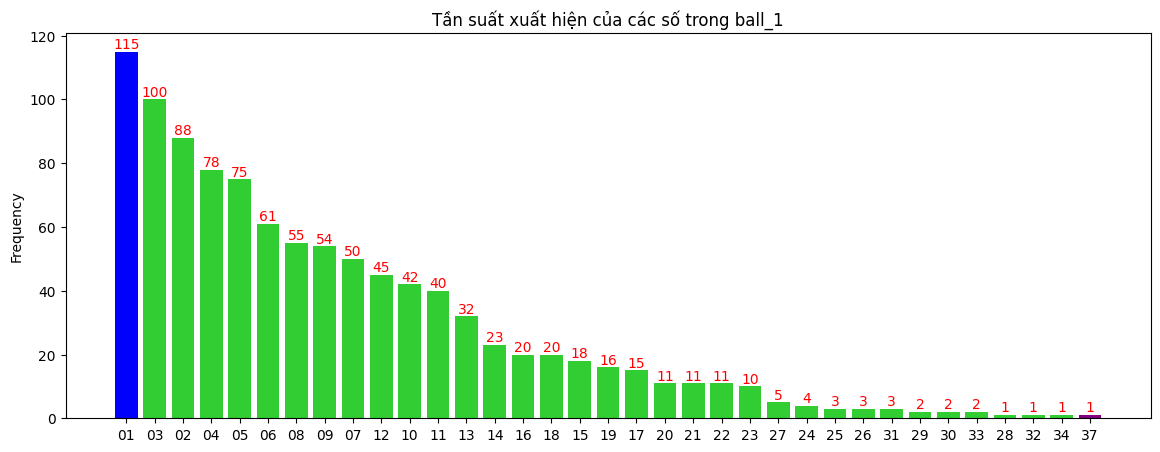

In [ ]:
import matplotlib.pyplot as plt

# Tính toán value_counts và sắp xếp
value_counts = draw_result['ball_1'].value_counts().sort_index().sort_values(ascending=False, kind='mergesort')

# Lấy giá trị lớn nhất và nhỏ nhất
max_ball = draw_result['ball_1'].max()
min_ball = draw_result['ball_1'].min()

# Tạo đồ thị
fig, ax = plt.subplots(figsize=(14,5))
bars = ax.bar(value_counts.index, value_counts.values
            , color=value_counts.index.map(lambda x: 'purple' if x == max_ball else 'blue' if x == min_ball else 'limegreen'))

# Thêm số liệu trên đầu các cột màu đỏ
for bar in bars:
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.05, bar.get_height(), ha='center', va='bottom', color='red')

# Đặt tiêu đề và nhãn
ax.set_ylabel("Frequency")
ax.set_title("Tần suất xuất hiện của các số trong ball_1")

# Hiển thị đồ thị
plt.show()

In [103]:
draw_result['ball_1'].value_counts().describe()

count     35.000000
mean      29.085714
std       31.773436
min        1.000000
25%        3.000000
50%       16.000000
75%       47.500000
max      115.000000
Name: count, dtype: float64

Với ball_1, ta thấy các số nhỏ, đặc biệt là số 01 xuất hiện rất thường xuyên, sau đó giảm dần đến bóng 37. Số từ 38 trở lên chưa bao giờ xuất hiện với ball_1.

Điều này có thể dẫn đến kết luận là với các kỳ quay, số bé nhất trong 6 số khó có khả năng lớn hơn 37. Điều này không có nghĩa là không thể xảy ra nhưng nó rất hiếm.

Ví dụ kết quả một kỳ quay thưởng cho 6 bóng là: [49, 50, 51, 52, 53, 54, 55] là rất khó có khả năng xảy ra nhưng không có nghĩa là không thể.

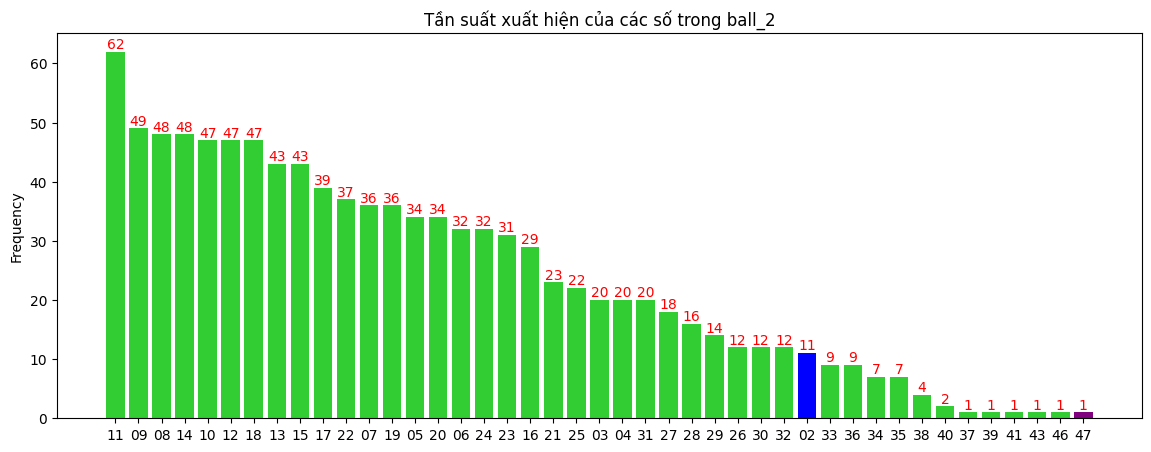

In [118]:
import matplotlib.pyplot as plt

# Tính toán value_counts và sắp xếp
value_counts = draw_result['ball_2'].value_counts().sort_index().sort_values(ascending=False, kind='mergesort')

# Lấy giá trị lớn nhất và nhỏ nhất
max_ball = draw_result['ball_2'].max()
min_ball = draw_result['ball_2'].min()

# Tạo đồ thị
fig, ax = plt.subplots(figsize=(14,5))
bars = ax.bar(value_counts.index, value_counts.values
            , color=value_counts.index.map(lambda x: 'purple' if x == max_ball else 'blue' if x == min_ball else 'limegreen'))

# Thêm số liệu trên đầu các cột màu đỏ
for bar in bars:
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.05, bar.get_height(), ha='center', va='bottom', color='red')

# Đặt tiêu đề và nhãn
ax.set_ylabel("Frequency")
ax.set_title("Tần suất xuất hiện của các số trong ball_2")

# Hiển thị đồ thị
plt.show()

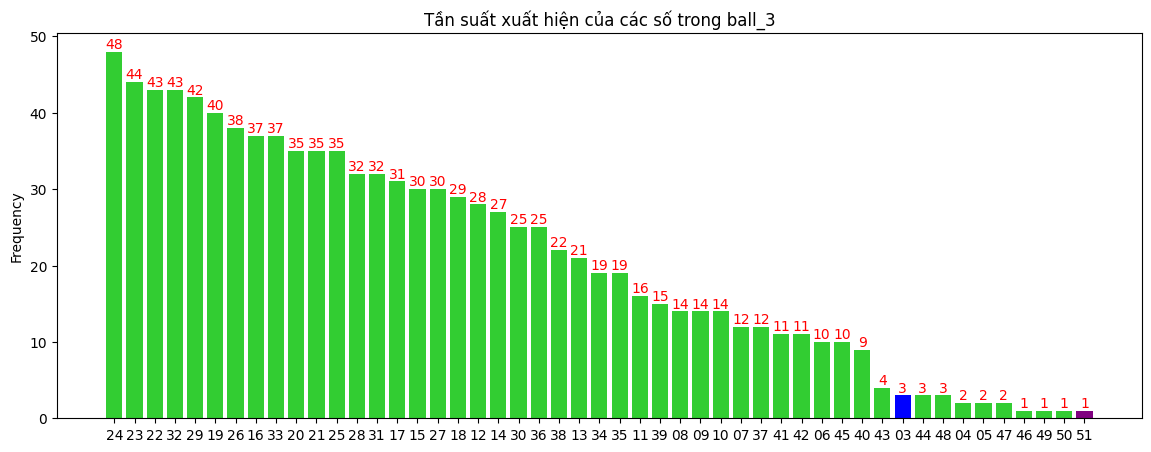

In [119]:
import matplotlib.pyplot as plt

# Tính toán value_counts và sắp xếp
value_counts = draw_result['ball_3'].value_counts().sort_index().sort_values(ascending=False, kind='mergesort')

# Lấy giá trị lớn nhất và nhỏ nhất
max_ball = draw_result['ball_3'].max()
min_ball = draw_result['ball_3'].min()

# Tạo đồ thị
fig, ax = plt.subplots(figsize=(14,5))
bars = ax.bar(value_counts.index, value_counts.values
            , color=value_counts.index.map(lambda x: 'purple' if x == max_ball else 'blue' if x == min_ball else 'limegreen'))

# Thêm số liệu trên đầu các cột màu đỏ
for bar in bars:
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.05, bar.get_height(), ha='center', va='bottom', color='red')

# Đặt tiêu đề và nhãn
ax.set_ylabel("Frequency")
ax.set_title("Tần suất xuất hiện của các số trong ball_3")

# Hiển thị đồ thị
plt.show()

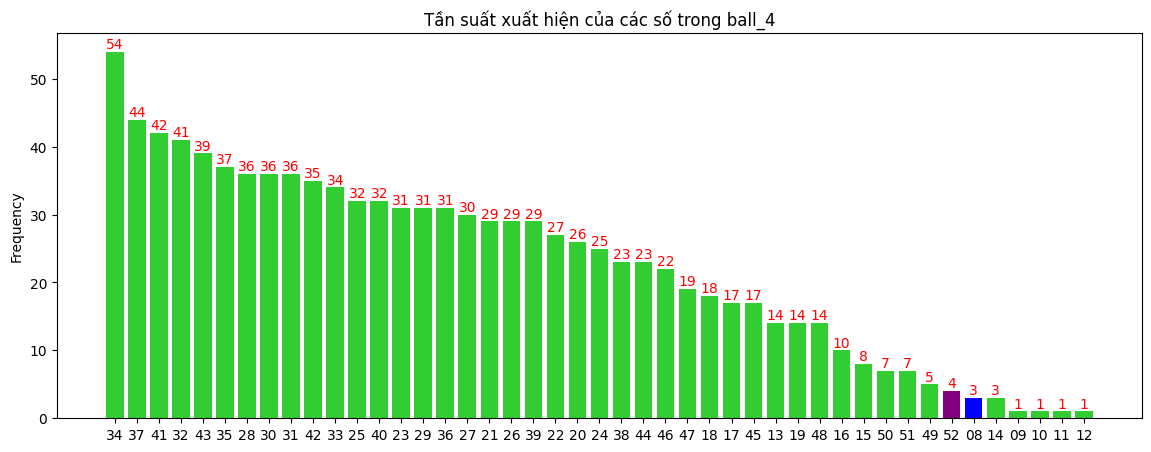

In [120]:
import matplotlib.pyplot as plt

# Tính toán value_counts và sắp xếp
value_counts = draw_result['ball_4'].value_counts().sort_index().sort_values(ascending=False, kind='mergesort')

# Lấy giá trị lớn nhất và nhỏ nhất
max_ball = draw_result['ball_4'].max()
min_ball = draw_result['ball_4'].min()

# Tạo đồ thị
fig, ax = plt.subplots(figsize=(14,5))
bars = ax.bar(value_counts.index, value_counts.values
            , color=value_counts.index.map(lambda x: 'purple' if x == max_ball else 'blue' if x == min_ball else 'limegreen'))

# Thêm số liệu trên đầu các cột màu đỏ
for bar in bars:
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.05, bar.get_height(), ha='center', va='bottom', color='red')

# Đặt tiêu đề và nhãn
ax.set_ylabel("Frequency")
ax.set_title("Tần suất xuất hiện của các số trong ball_4")

# Hiển thị đồ thị
plt.show()

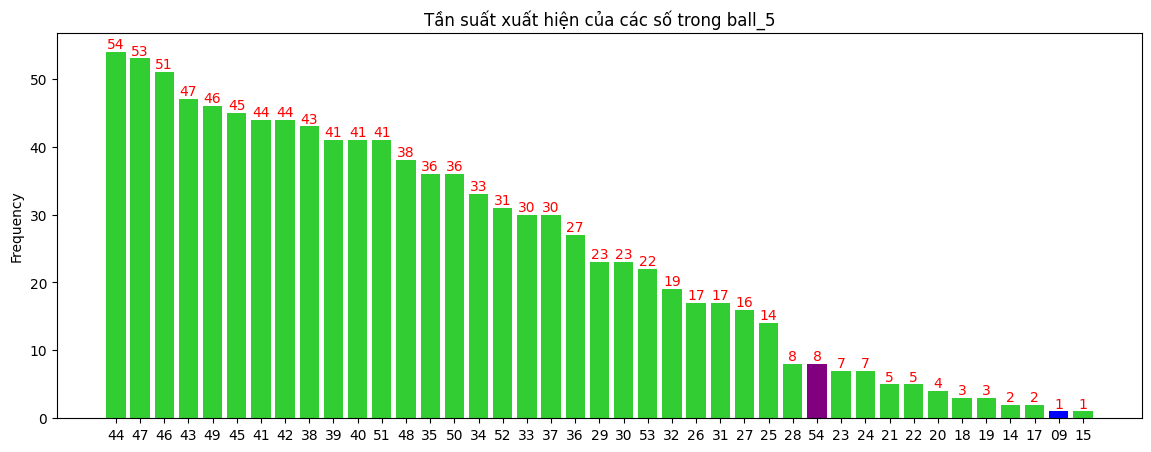

In [121]:
import matplotlib.pyplot as plt

# Tính toán value_counts và sắp xếp
value_counts = draw_result['ball_5'].value_counts().sort_index().sort_values(ascending=False, kind='mergesort')

# Lấy giá trị lớn nhất và nhỏ nhất
max_ball = draw_result['ball_5'].max()
min_ball = draw_result['ball_5'].min()

# Tạo đồ thị
fig, ax = plt.subplots(figsize=(14,5))
bars = ax.bar(value_counts.index, value_counts.values
            , color=value_counts.index.map(lambda x: 'purple' if x == max_ball else 'blue' if x == min_ball else 'limegreen'))

# Thêm số liệu trên đầu các cột màu đỏ
for bar in bars:
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.05, bar.get_height(), ha='center', va='bottom', color='red')

# Đặt tiêu đề và nhãn
ax.set_ylabel("Frequency")
ax.set_title("Tần suất xuất hiện của các số trong ball_5")

# Hiển thị đồ thị
plt.show()

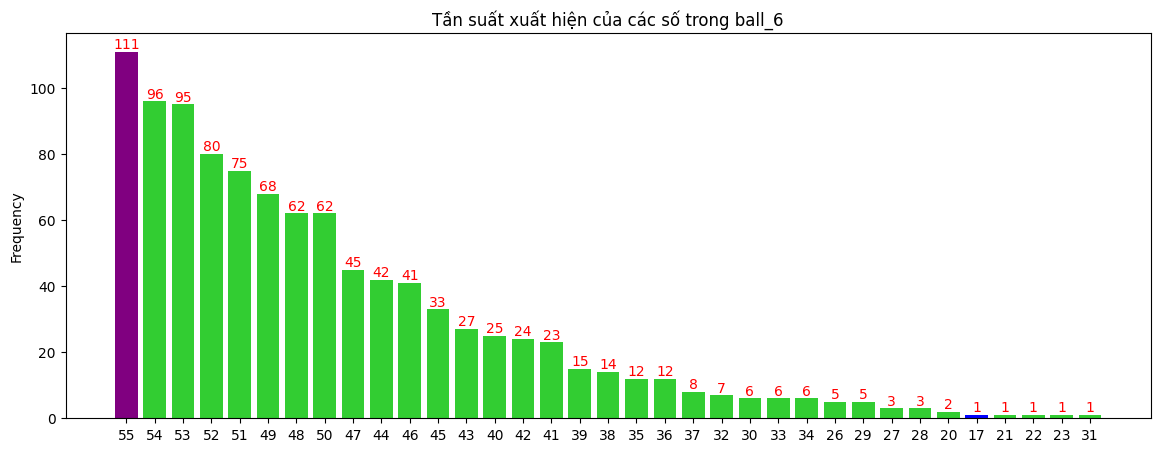

In [122]:
import matplotlib.pyplot as plt

# Tính toán value_counts và sắp xếp
value_counts = draw_result['ball_6'].value_counts().sort_index().sort_values(ascending=False, kind='mergesort')

# Lấy giá trị lớn nhất và nhỏ nhất
max_ball = draw_result['ball_6'].max()
min_ball = draw_result['ball_6'].min()

# Tạo đồ thị
fig, ax = plt.subplots(figsize=(14,5))
bars = ax.bar(value_counts.index, value_counts.values
            , color=value_counts.index.map(lambda x: 'purple' if x == max_ball else 'blue' if x == min_ball else 'limegreen'))

# Thêm số liệu trên đầu các cột màu đỏ
for bar in bars:
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.05, bar.get_height(), ha='center', va='bottom', color='red')

# Đặt tiêu đề và nhãn
ax.set_ylabel("Frequency")
ax.set_title("Tần suất xuất hiện của các số trong ball_6")

# Hiển thị đồ thị
plt.show()

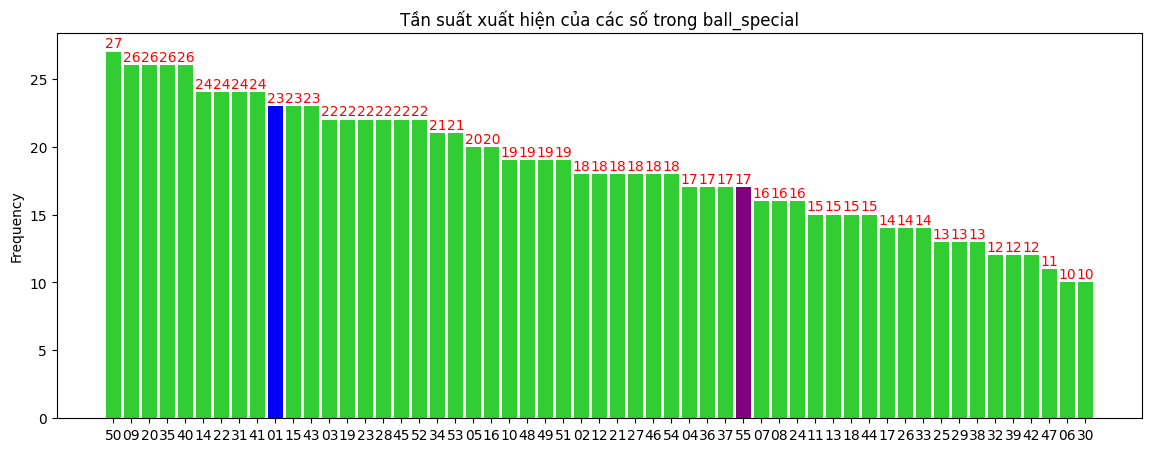

In [123]:
import matplotlib.pyplot as plt

# Tính toán value_counts và sắp xếp
value_counts = draw_result['ball_special'].value_counts().sort_index().sort_values(ascending=False, kind='mergesort')

# Lấy giá trị lớn nhất và nhỏ nhất
max_ball = draw_result['ball_special'].max()
min_ball = draw_result['ball_special'].min()

# Tạo đồ thị
fig, ax = plt.subplots(figsize=(14,5))
bars = ax.bar(value_counts.index, value_counts.values
            , color=value_counts.index.map(lambda x: 'purple' if x == max_ball else 'blue' if x == min_ball else 'limegreen'))

# Thêm số liệu trên đầu các cột màu đỏ
for bar in bars:
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.05, bar.get_height(), ha='center', va='bottom', color='red')

# Đặt tiêu đề và nhãn
ax.set_ylabel("Frequency")
ax.set_title("Tần suất xuất hiện của các số trong ball_special")

# Hiển thị đồ thị
plt.show()

### Chênh lệch số

Thông thường trong power 6/55, giữa các ball liền kề nhau, chênh lệch nhau khoảng 1 đến 20. Các mức chênh lệch cao hơn có thể xảy ra nhưng khá là hiếm

In [124]:
draw_result['delta_1_2'] = draw_result['ball_2'].astype('int') - draw_result['ball_1'].astype('int')
draw_result['delta_2_3'] = draw_result['ball_3'].astype('int') - draw_result['ball_2'].astype('int')
draw_result['delta_3_4'] = draw_result['ball_4'].astype('int') - draw_result['ball_3'].astype('int')
draw_result['delta_4_5'] = draw_result['ball_5'].astype('int') - draw_result['ball_4'].astype('int')
draw_result['delta_5_6'] = draw_result['ball_6'].astype('int') - draw_result['ball_5'].astype('int')
draw_result.head()

,draw_ID,draw_date,ball_1,ball_2,ball_3,ball_4,ball_5,ball_6,ball_special,delta_1_2,delta_2_3,delta_3_4,delta_4_5,delta_5_6
0,1,2017-08-01,05,10,14,23,24,38,35,5,4,9,1,14
1,2,2017-08-03,04,09,24,25,27,45,40,5,15,1,2,18
2,3,2017-08-05,01,05,11,32,40,45,43,4,6,21,8,5
3,4,2017-08-08,19,36,39,41,46,51,38,17,3,2,5,5
4,5,2017-08-10,10,11,19,41,50,54,03,1,8,22,9,4


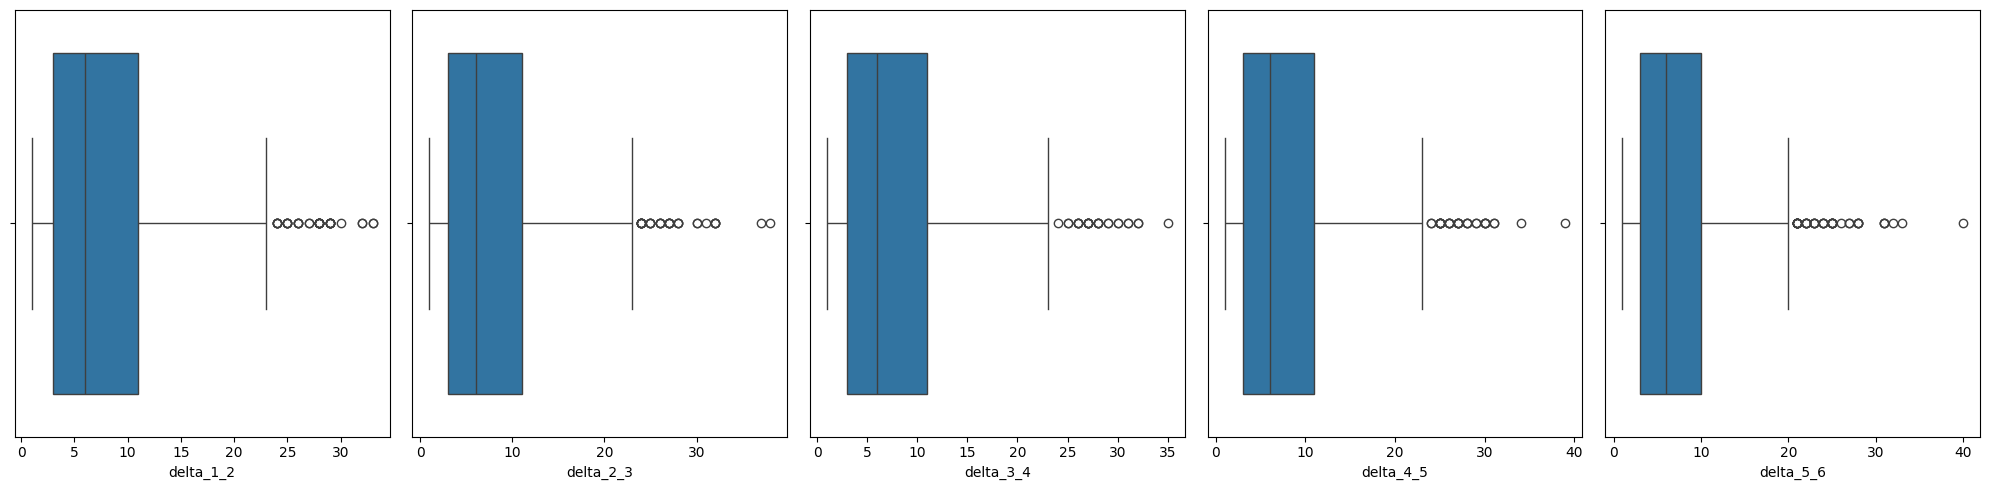

In [125]:
# Tạo một figure và một set của subplots
fig, axs = plt.subplots(nrows=1, ncols=5, figsize=(20, 5))

# Vẽ các boxplot cho mỗi delta
# ax = sns.boxplot(x=draw_result['delta_1_2'])
sns.boxplot(x='delta_1_2', data=draw_result, ax=axs[0])
sns.boxplot(x='delta_2_3', data=draw_result, ax=axs[1])
sns.boxplot(x='delta_3_4', data=draw_result, ax=axs[2])
sns.boxplot(x='delta_4_5', data=draw_result, ax=axs[3])
sns.boxplot(x='delta_5_6', data=draw_result, ax=axs[4])

# Hiển thị biểu đồ
plt.tight_layout()
plt.show()


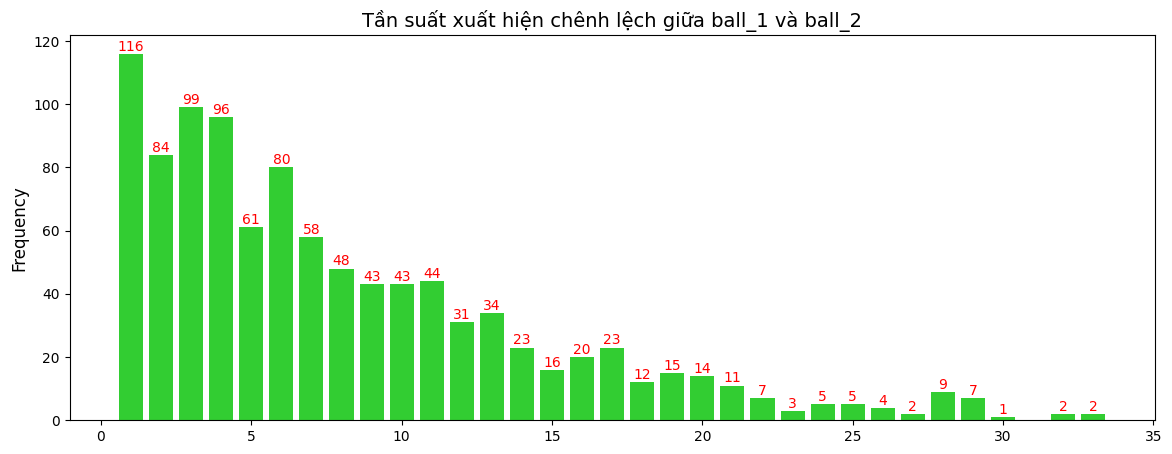

In [22]:
fig, ax = plt.subplots(figsize=(14,5))
bars = ax.bar(draw_result['delta_1_2'].value_counts().index,
              draw_result['delta_1_2'].value_counts().values,
              color='limegreen')  # Đặt màu cho cột tại đây
# Đặt màu cho cột
# colors = ['red', 'green', 'blue', 'cyan', 'magenta', 'yellow', 'black', 'white']  # Bạn có thể thay đổi danh sách màu

# Thêm số liệu trên đầu các cột
for bar in bars:
    yval = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2, yval + 0.05, yval, ha='center', va='bottom', color='red')

ax.set_ylabel("Frequency", size=12)
ax.set_title("Tần suất xuất hiện chênh lệch giữa ball_1 và ball_2", size=14)
plt.show()

Với chênh lệch giữa ball_1 và ball_2, ta thấy chênh lệch 1 giá số có tần suất nhiều nhất, chênh lệch lớn hơn 33 số chưa bao giờ xảy ra.

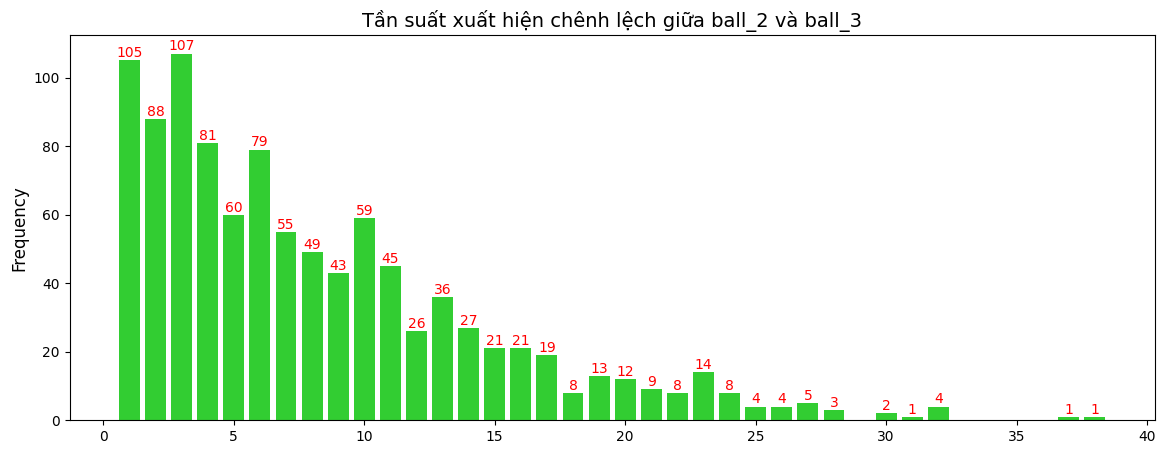

In [23]:
fig, ax = plt.subplots(figsize=(14,5))
bars = ax.bar(draw_result['delta_2_3'].value_counts().index,
              draw_result['delta_2_3'].value_counts().values,
              color='limegreen')  # Đặt màu cho cột tại đây
# Đặt màu cho cột
# colors = ['red', 'green', 'blue', 'cyan', 'magenta', 'yellow', 'black', 'white']  # Bạn có thể thay đổi danh sách màu

# Thêm số liệu trên đầu các cột
for bar in bars:
    yval = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2, yval + 0.05, yval, ha='center', va='bottom', color='red')

ax.set_ylabel("Frequency", size=12)
ax.set_title("Tần suất xuất hiện chênh lệch giữa ball_2 và ball_3", size=14)
plt.show()

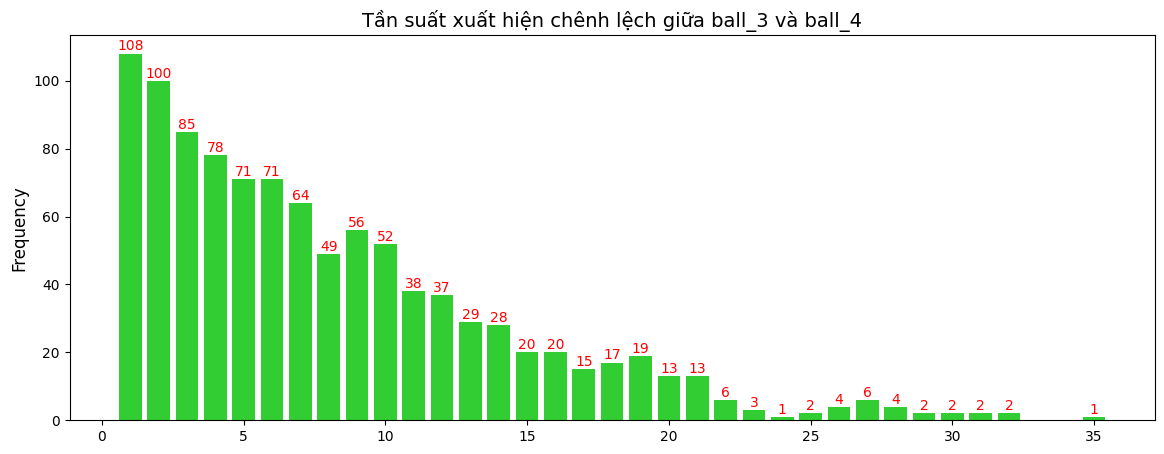

In [24]:
fig, ax = plt.subplots(figsize=(14,5))
bars = ax.bar(draw_result['delta_3_4'].value_counts().index,
              draw_result['delta_3_4'].value_counts().values,
              color='limegreen')  # Đặt màu cho cột tại đây
# Đặt màu cho cột
# colors = ['red', 'green', 'blue', 'cyan', 'magenta', 'yellow', 'black', 'white']  # Bạn có thể thay đổi danh sách màu

# Thêm số liệu trên đầu các cột
for bar in bars:
    yval = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2, yval + 0.05, yval, ha='center', va='bottom', color='red')

ax.set_ylabel("Frequency", size=12)
ax.set_title("Tần suất xuất hiện chênh lệch giữa ball_3 và ball_4", size=14)
plt.show()

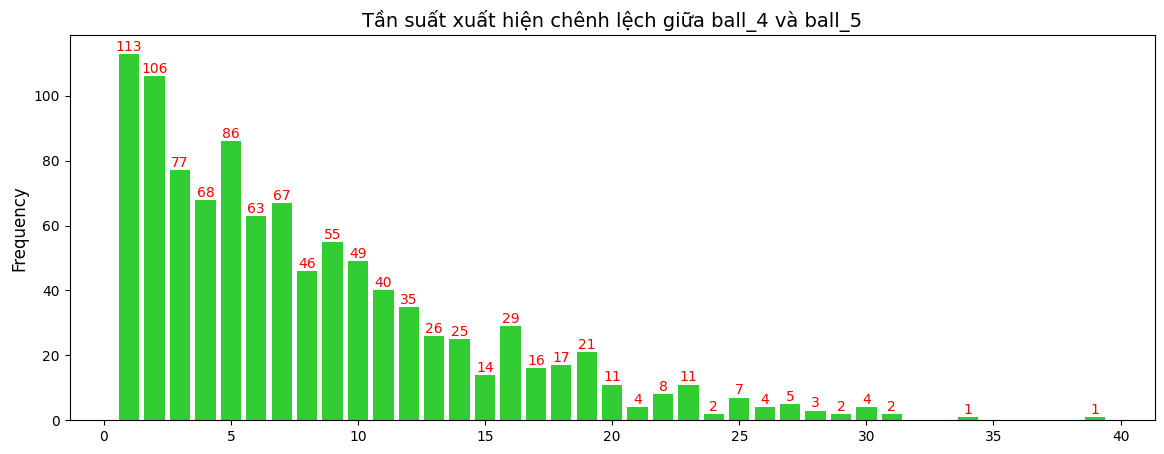

In [25]:
fig, ax = plt.subplots(figsize=(14,5))
bars = ax.bar(draw_result['delta_4_5'].value_counts().index,
              draw_result['delta_4_5'].value_counts().values,
              color='limegreen')  # Đặt màu cho cột tại đây
# Đặt màu cho cột
# colors = ['red', 'green', 'blue', 'cyan', 'magenta', 'yellow', 'black', 'white']  # Bạn có thể thay đổi danh sách màu

# Thêm số liệu trên đầu các cột
for bar in bars:
    yval = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2, yval + 0.05, yval, ha='center', va='bottom', color='red')

ax.set_ylabel("Frequency", size=12)
ax.set_title("Tần suất xuất hiện chênh lệch giữa ball_4 và ball_5", size=14)
plt.show()

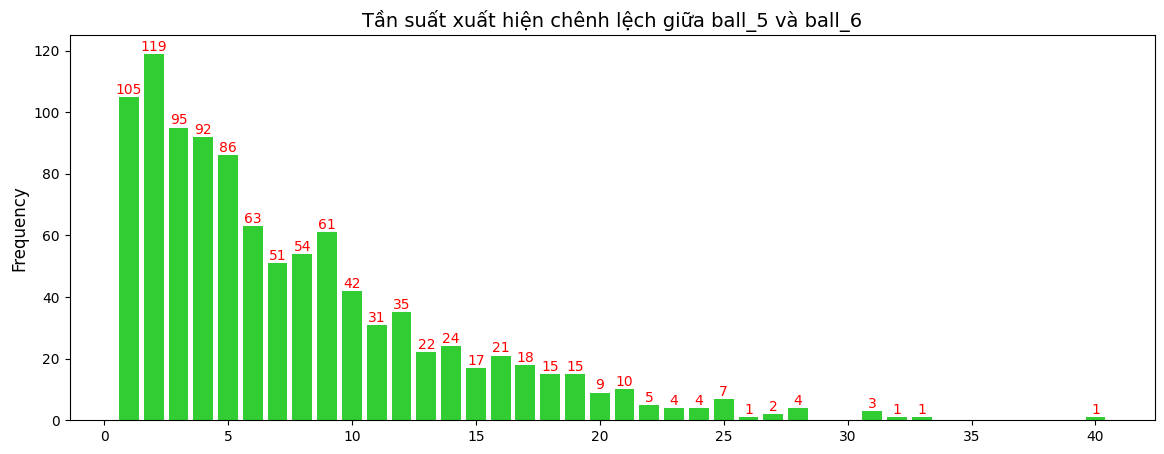

In [26]:
fig, ax = plt.subplots(figsize=(14,5))
bars = ax.bar(draw_result['delta_5_6'].value_counts().index,
              draw_result['delta_5_6'].value_counts().values,
              color='limegreen')  # Đặt màu cho cột tại đây
# Đặt màu cho cột
# colors = ['red', 'green', 'blue', 'cyan', 'magenta', 'yellow', 'black', 'white']  # Bạn có thể thay đổi danh sách màu

# Thêm số liệu trên đầu các cột
for bar in bars:
    yval = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2, yval + 0.05, yval, ha='center', va='bottom', color='red')

ax.set_ylabel("Frequency", size=12)
ax.set_title("Tần suất xuất hiện chênh lệch giữa ball_5 và ball_6", size=14)
plt.show()

### Phân tích tổng các số

In [131]:
draw_result['total_number'] = draw_result['ball_1'].astype('int') + draw_result['ball_2'].astype('int') \
                                + draw_result['ball_3'].astype('int') + draw_result['ball_4'].astype('int') \
                                + draw_result['ball_5'].astype('int') + draw_result['ball_6'].astype('int')
draw_result['total_number'].describe()

count    1018.000000
mean      169.401768
std        37.732989
min        55.000000
25%       143.000000
50%       171.000000
75%       195.750000
max       288.000000
Name: total_number, dtype: float64

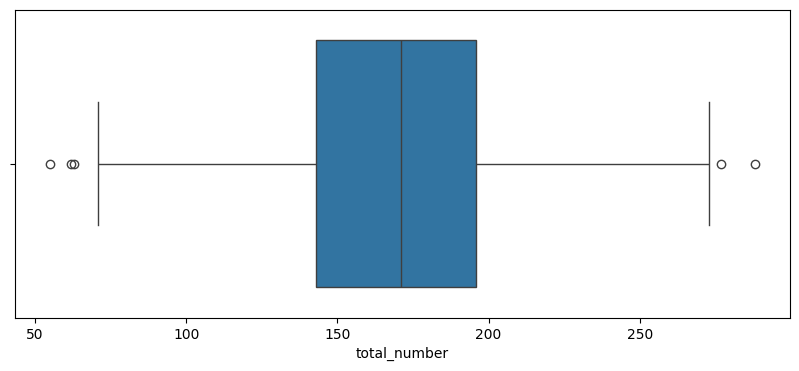

In [132]:
ax = sns.boxplot(x=draw_result['total_number'])

Kiểm tra phân phối của tổng các số:

C:\Users\admin\AppData\Local\Temp\ipykernel_21848\939682642.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  ax = sns.distplot(draw_result['total_number'])


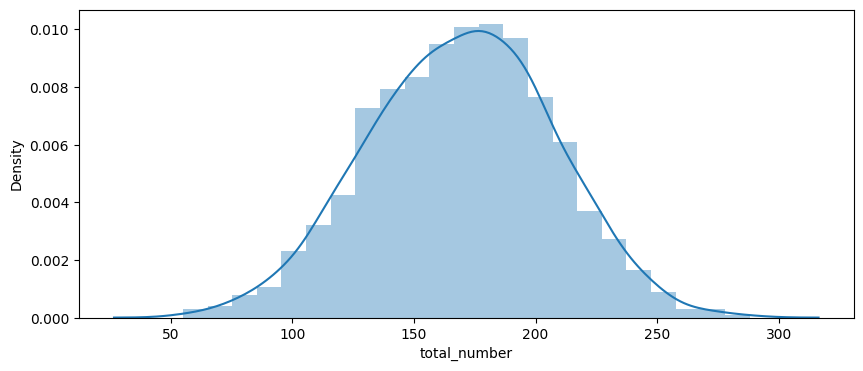

In [133]:
plt.rc("figure", figsize=(10, 4))
ax = sns.distplot(draw_result['total_number'])


In [135]:
# Lấy dữ liệu từ cột "total_number"
data = draw_result['total_number'].to_numpy()

# Kiểm định Shapiro-Wilk
w, pvalue = shapiro(data)

# In kết quả
print('Thống kê W:', w)
print('Giá trị p:', pvalue)

# Phân tích kết quả
if pvalue < 0.05:
  print('Dữ liệu không tuân theo phân phối chuẩn.')
else:
  print('Dữ liệu có tuân theo phân phối chuẩn.')

Thống kê W: 0.9986812472343445
Giá trị p: 0.6614052057266235
Dữ liệu có tuân theo phân phối chuẩn.


Ta thấy tổng các số trong một kỳ quay có dạng hình chuông của phân phối chuẩn, đồng thời kiểm định shapiro cho W = 0.9986812472343445 là một giá trị khá cao, gần với 1, cho thấy dữ liệu có thể gần với phân phối chuẩn.

Với việc tổng các số tuân theo phân phối chuẩn, ta có nhiều ý tưởng và phương pháp phù hợp để dự báo như Arima, naive bayes... hay ANN có hiệu suất tốt với dữ liệu chuẩn hóa.

## Phân tích giá trị giải thưởng

Phân tích giá trị tăng thêm của jackpot 1 qua mỗi kỳ quay

In [43]:
# Lấy giá trị giải jackpot 1 qua các kỳ quay
jackpot1_prize = prize_result.query("prize == 'Jackpot 1'")[['draw_ID', 'draw_date', 'prize_value']] \
                                .sort_values(by='draw_ID', ascending=True).reset_index(drop=True)
diff_jackpot1_prize_result = jackpot1_prize['prize_value'].diff().apply(lambda x: max(0, x))

# Đặt giá trị của diff_jackpot1_prize_result cho hàng đầu tiên thành 0
diff_jackpot1_prize_result.iloc[0] = 0

# Thêm cột 'delta_value' vào DataFrame
jackpot1_prize['delta_value'] = diff_jackpot1_prize_result
jackpot1_prize['delta_value'] = jackpot1_prize['delta_value'].astype('int64')

jackpot1_prize


,draw_ID,draw_date,prize_value,delta_value
0,1,2017-08-01,30528493950,0
1,2,2017-08-03,31024813350,496319400
2,3,2017-08-05,31903413600,878600250
3,4,2017-08-08,33415353750,1511940150
4,5,2017-08-10,34588091550,1172737800
...,...,...,...,...
1013,1014,2024-03-28,300000000000,2954862900
1014,1015,2024-03-30,300000000000,0
1015,1016,2024-04-02,317948300400,17948300400
1016,1017,2024-04-04,337543447350,19595146950


Text(0.5, 1.0, 'Biểu đồ giá trị tăng thêm của jackpot 1 giữa các kỳ quay thưởng')

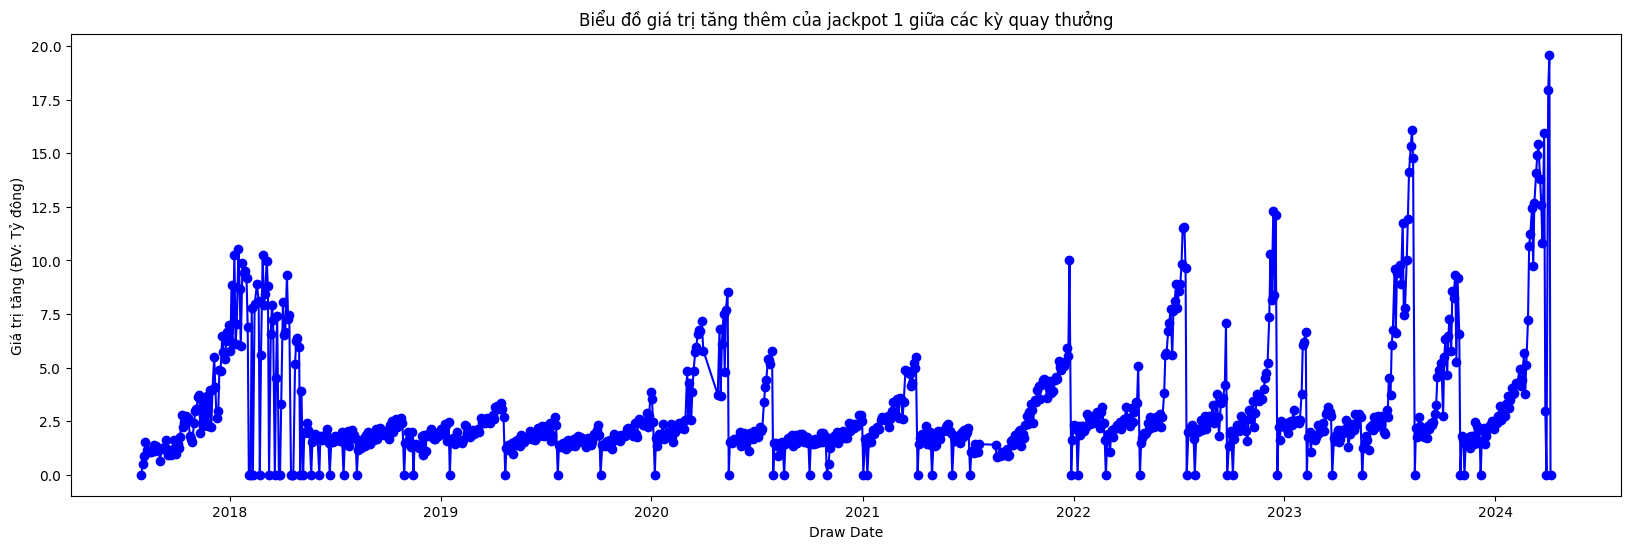

In [44]:
# Thiết lập kích thước của biểu đồ
plt.figure(figsize=(20, 6))

# Vẽ biểu đồ đường nối
plt.plot(jackpot1_prize['draw_date'], jackpot1_prize['delta_value'] / 1000000000, marker='o', linestyle='-', color='b')

# Đặt nhãn cho trục x và trục y
plt.xlabel('Draw Date')
plt.ylabel('Giá trị tăng (ĐV: Tỷ đông)')  # Đặt nhãn cho trục y với đơn vị đã được rút ngắn

# Đặt tiêu đề cho biểu đồ
plt.title('Biểu đồ giá trị tăng thêm của jackpot 1 giữa các kỳ quay thưởng')

# Xóa các dấu phẩy trên trục y (nếu có)
# plt.gca().get_yaxis().set_major_formatter(plt.FuncFormatter(lambda x, loc: "{:,.0f}".format(x)))

# Xếp xác nhận đsubplot

Phân tích tổng giá trị trao giải

In [31]:
prize_result['total_prize'] = prize_result['number_of_prizes'] * prize_result['prize_value']
total_prize_result = prize_result.groupby(['draw_ID', 'draw_date'])['total_prize'].sum().reset_index()
total_prize_result['draw_date'] = pd.to_datetime(total_prize_result['draw_date'])
total_prize_result

,draw_ID,draw_date,total_prize
0,1,2017-08-01,406200000
1,2,2017-08-03,1032200000
2,3,2017-08-05,785800000
3,4,2017-08-08,498400000
4,5,2017-08-10,575100000
...,...,...,...
1013,1014,2024-03-28,23411147100
1014,1015,2024-03-30,27763076000
1015,1016,2024-04-02,6654550000
1016,1017,2024-04-04,6346150000


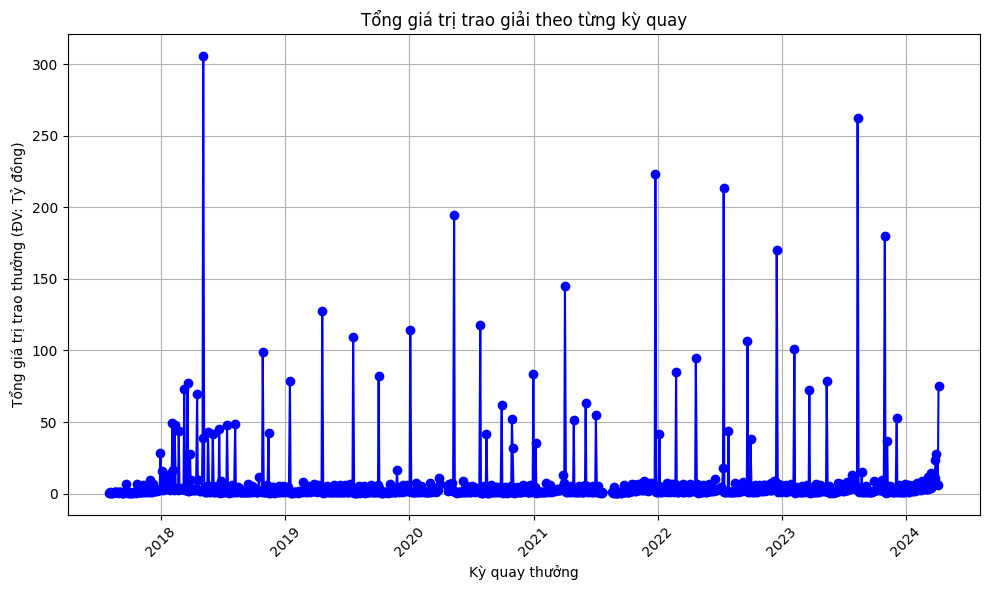

In [34]:
# Vẽ biểu đồ
plt.figure(figsize=(10, 6))  # Đặt kích thước cho biểu đồ
# Vẽ biểu đồ đường với marker
plt.plot(total_prize_result['draw_date'], total_prize_result['total_prize'] / 1000000000, marker='o', linestyle='-', color='blue')
plt.title('Tổng giá trị trao giải theo từng kỳ quay')  # Tiêu đề
plt.xlabel('Kỳ quay thưởng')  # Nhãn trục x
plt.ylabel('Tổng giá trị trao thưởng (ĐV: Tỷ đồng)')  # Nhãn trục y
plt.grid(True)  # Hiển thị lưới
plt.xticks(rotation=45)  # Xoay nhãn trục x
plt.tight_layout()  # Tự động điều chỉnh layout

# Hiển thị biểu đồ
plt.show()

# 2. Phân tích các kỳ quay trúng giải jackpot 1

In [47]:
# jackpot_draw_ID = prize_result.loc[(prize_result['number_of_prizes'] >= 1) & (prize_result['prize'] == 'Jackpot 1'), 'draw_ID']
jackpot1_prize_result = prize_result.query("number_of_prizes >= 1 and prize == 'Jackpot 1'")[['draw_ID', 'draw_date', 'prize_value']]

# jackpot_draw_result = (
#     draw_result
#     .merge(jackpot_draw_ID.to_frame(), on='draw_ID', how='inner', indicator=True)
#     .drop(columns=['_merge'])
# )
jackpot1_draw_result = draw_result[draw_result['draw_ID'].isin(jackpot1_prize_result['draw_ID'])] \
                                .sort_values(by='draw_ID', ascending=True).reset_index(drop=True)
jackpot1_draw_result['draw_date'] = pd.to_datetime(jackpot1_draw_result['draw_date'])
jackpot1_draw_result['weekday'] = jackpot1_draw_result['draw_date'].dt.strftime('%a')
jackpot1_draw_result.head()


,draw_ID,draw_date,ball_1,ball_2,ball_3,ball_4,ball_5,ball_6,ball_special,delta_1_2,delta_2_3,delta_3_4,delta_4_5,delta_5_6,total_number,weekday
0,119,2018-05-05,16,32,33,37,40,48,15,16,1,4,3,8,206,Sat
1,125,2018-05-19,33,35,45,52,53,55,25,2,10,7,1,2,273,Sat
2,131,2018-06-02,05,07,17,22,32,33,06,2,10,5,10,1,116,Sat
3,139,2018-06-21,02,08,19,23,25,33,32,6,11,4,2,8,110,Thu
4,149,2018-07-14,04,19,23,34,38,50,01,15,4,11,4,12,168,Sat


Phân tích tần suất trúng giải jackpot 1 theo thứ trong tuần

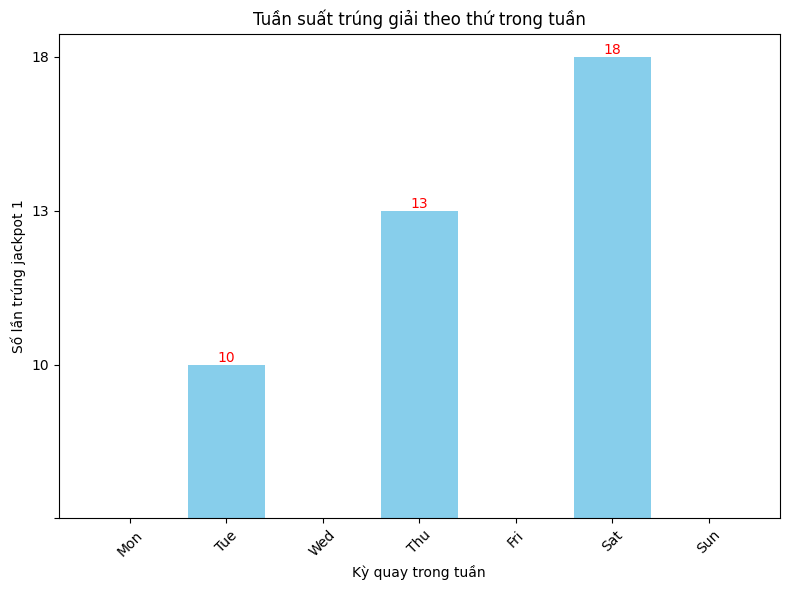

In [46]:
# Tính số lần xuất hiện của mỗi ngày trong tuần và điền các giá trị thiếu
weekday_counts = jackpot1_draw_result['weekday'].value_counts().reindex(['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'], fill_value=0).fillna(0)

# Loại bỏ việc hiển thị số 0 cho các ngày không có kết quả
weekday_counts = weekday_counts.apply(lambda x: '' if x == 0 else str(int(x)))

# Đặt hằng số nhân để điều chỉnh tỷ lệ chiều cao của các cột
height_factor = 1

# Vẽ biểu đồ cột
plt.figure(figsize=(8, 6))
bars = plt.bar(weekday_counts.index, weekday_counts, color='skyblue')
# Thêm số màu đỏ ở đầu mỗi cột
for bar, value in zip(bars, weekday_counts):
    if value != '':
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width() / 2, height, value, ha='center', va='bottom', color='red')
        bar.set_height(height * height_factor)  # Điều chỉnh chiều cao của cột
plt.xlabel('Kỳ quay trong tuần')
plt.title('Tuần suất trúng giải theo thứ trong tuần')
plt.xticks(rotation=45)
plt.ylabel('Số lần trúng jackpot 1')

plt.tight_layout()
plt.show()

In [50]:
# Thống kê số lần xuất hiện của từng số
jackpot1_frequency_number = jackpot1_draw_result.iloc[:, 2:7] \
                                .stack() \
                                .value_counts() \
                                .sort_values(ascending=True)
jackpot1_frequency_number

52     1
53     1
48     1
49     1
31     1
36     1
50     1
05     2
10     2
42     3
27     3
43     3
45     3
40     3
18     3
12     3
13     3
17     3
28     3
20     4
35     4
09     4
21     4
39     4
16     4
01     4
24     4
26     4
44     4
30     5
41     5
07     5
33     5
11     5
06     5
23     5
14     5
37     5
34     5
38     5
03     5
19     5
32     6
22     6
15     6
02     6
29     7
08     9
25     9
04    10
Name: count, dtype: int64

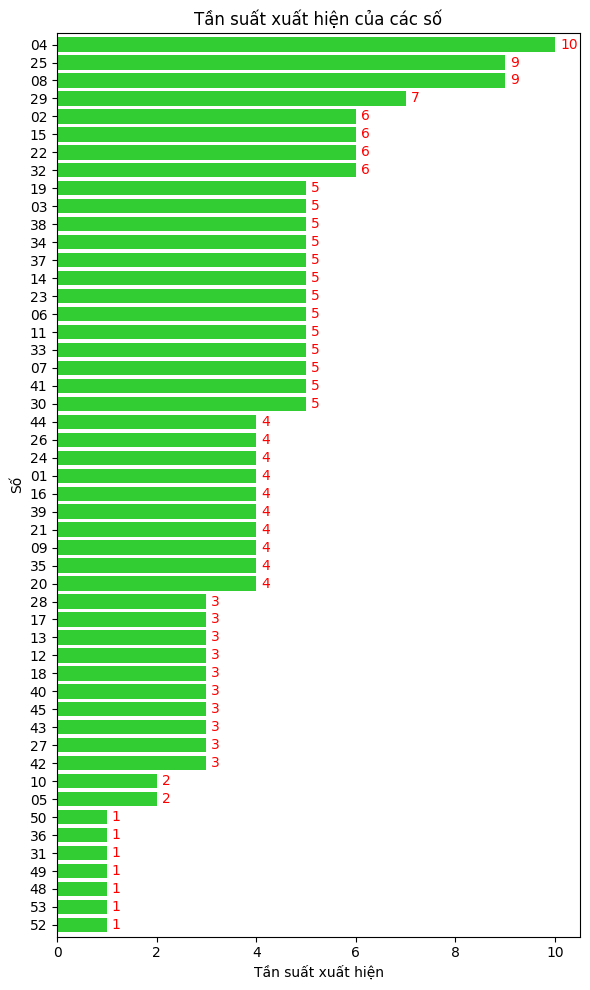

In [61]:
jackpot1_frequency_number.plot(kind='barh', figsize=(6, 10), color='limegreen', width=0.8)
plt.xlabel('Tần suất xuất hiện')
plt.ylabel('Số')
plt.title('Tần suất xuất hiện của các số khi trúng jackpot 1')

# Hiển thị số liệu bên phải mỗi cột và thay đổi màu sắc
for i, (index, value) in enumerate(jackpot1_frequency_number.items()):
    plt.text(value + 0.1, i, str(value), color='red', va='center')

plt.tight_layout()
plt.show()

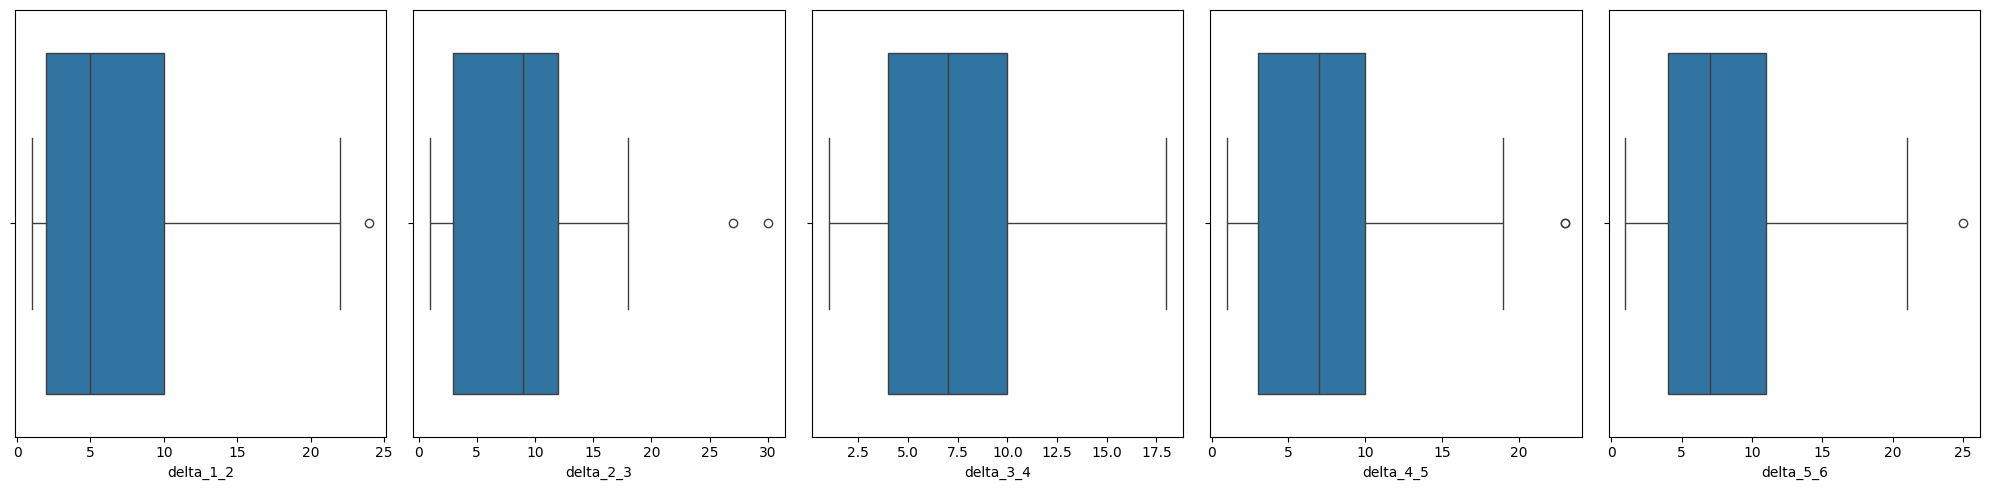

In [62]:
# Tạo một figure và một set của subplots
fig, axs = plt.subplots(nrows=1, ncols=5, figsize=(20, 5))

# Vẽ các boxplot cho mỗi delta
# ax = sns.boxplot(x=draw_result['delta_1_2'])
sns.boxplot(x='delta_1_2', data=jackpot1_draw_result, ax=axs[0])
sns.boxplot(x='delta_2_3', data=jackpot1_draw_result, ax=axs[1])
sns.boxplot(x='delta_3_4', data=jackpot1_draw_result, ax=axs[2])
sns.boxplot(x='delta_4_5', data=jackpot1_draw_result, ax=axs[3])
sns.boxplot(x='delta_5_6', data=jackpot1_draw_result, ax=axs[4])

# Hiển thị biểu đồ
plt.tight_layout()
plt.show()

C:\Users\admin\AppData\Local\Temp\ipykernel_21848\4081143553.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  ax = sns.distplot(jackpot1_draw_result['total_number'])


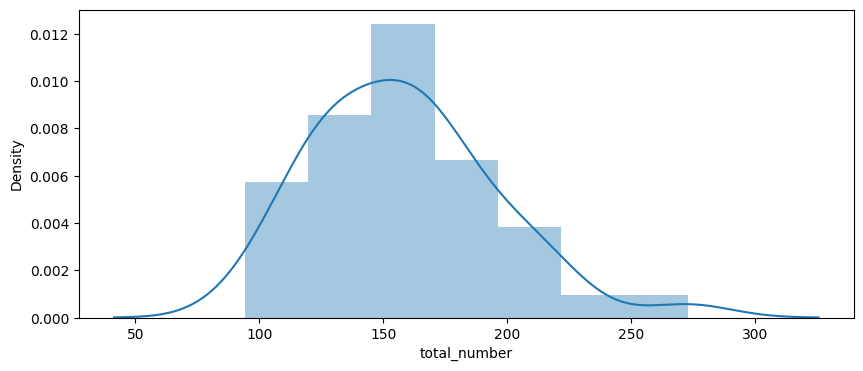

In [48]:
plt.rc("figure", figsize=(10, 4))
ax = sns.distplot(jackpot1_draw_result['total_number'])

## 3. Dự đoán bằng kerras

Lấy dữ liệu từ ball_1 đến ball_6 làm dữ liệu cho kerras

In [145]:
kerras_data = draw_result.iloc[:, 2:-7].astype(int)
kerras_data

,ball_1,ball_2,ball_3,ball_4,ball_5,ball_6
0,5,10,14,23,24,38
1,4,9,24,25,27,45
2,1,5,11,32,40,45
3,19,36,39,41,46,51
4,10,11,19,41,50,54
...,...,...,...,...,...,...
1013,1,7,18,26,38,49
1014,14,17,27,38,54,55
1015,1,12,18,20,51,52
1016,3,8,12,25,47,48


In [147]:
def _load_data(df, n_prev=30):
    docX, docY = [], []
    for i in range(len(df) - n_prev):
        docX.append(df.iloc[i:i + n_prev].values)
        docY.append(df.iloc[i + n_prev].values)
    alsX = np.array(docX)
    alsY = np.array(docY)
    return alsX, alsY

def train_test_split(df, test_size=0.2):
    num_train = round(len(df) * (1 - test_size))
    X_train, y_train = _load_data(df.iloc[0:num_train])
    X_test, y_test = _load_data(df.iloc[num_train:])
    return X_train, y_train, X_test, y_test

X_train, y_train, X_test, y_test = train_test_split(kerras_data)

In [148]:
model = Sequential()
model.add(LSTM(16, input_shape=(None, 6)))
model.add(Dense(6, input_dim=16))
model.compile(loss="mse", optimizer="adam")

In [149]:
hist = model.fit(X_train, y_train, batch_size=339, epochs=10, validation_split=0.1)

Epoch 1/10
3/3 [==============================] - 3s 250ms/step - loss: 1071.5724 - val_loss: 1061.3763
Epoch 2/10
3/3 [==============================] - 0s 30ms/step - loss: 1068.9027 - val_loss: 1058.9653
Epoch 3/10
3/3 [==============================] - 0s 35ms/step - loss: 1066.6063 - val_loss: 1056.9575
Epoch 4/10
3/3 [==============================] - 0s 35ms/step - loss: 1064.6025 - val_loss: 1055.2505
Epoch 5/10
3/3 [==============================] - 0s 36ms/step - loss: 1062.8002 - val_loss: 1053.6816
Epoch 6/10
3/3 [==============================] - 0s 43ms/step - loss: 1060.7963 - val_loss: 1050.3855
Epoch 7/10
3/3 [==============================] - 0s 35ms/step - loss: 1058.0474 - val_loss: 1047.5109
Epoch 8/10
3/3 [==============================] - 0s 29ms/step - loss: 1054.9318 - val_loss: 1045.8821
Epoch 9/10
3/3 [==============================] - 0s 34ms/step - loss: 1052.9341 - val_loss: 1043.8822
Epoch 10/10
3/3 [==============================] - 0s 37ms/step - loss: 

In [151]:
predicted = model.predict(X_test)
rmse = np.sqrt(((predicted - y_test) ** 2).mean(axis=0))
print(f"\nPredicted numbers: {np.around(rmse)}")

6/6 [==============================] - 0s 5ms/step



Predicted numbers: [11. 19. 27. 34. 42. 48.]
